In [1]:
import os
import sys
sys.path.append('../src')
import time

import numpy as np
import cvxpy as cp
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='ticks', font_scale=1.5)
mpl.rcParams["text.usetex"] = True
mpl.rcParams["mathtext.fontset"] = 'cm'
mpl.rcParams['font.family'] = ['sans-serif']

from algorithms import vi_policy

In [2]:
if not os.path.exists('../figures'):
    os.makedirs('../figures')

In [3]:
pi_exp = np.load('../data/pi.npy')
P = np.load('../data/P.npy')

num_states = P.shape[0]
gridsize = int(np.sqrt(num_states))
num_actions = P.shape[-1]

Pastr = []
lPa = []
for s_idx in range(num_states):
    astr = np.argmax(pi_exp[s_idx, :])
    a = np.delete(np.arange(num_actions), astr)
    Pastr.append(P[s_idx, :, astr])
    lPa.append(P[s_idx, :, a])
Pastr = np.array(Pastr)
lPa = np.array(lPa).transpose(1, 0, 2)

In [4]:
# problem information (input from user)
m = num_states  # number of states
gamma = 0.9  # discount factor
Pastr = Pastr  # transition matrix of the optimal action
lPa = lPa  # list of transition matrices of the other actions

# hyperparameters (input from user)
rmax = 100  # reward function bound
lbd = 2  # scalarization weight

r = cp.Variable(m)
s = cp.Variable(m)

constraints = []
H = np.linalg.inv(np.identity(m) - gamma * Pastr)
D = np.array([[Pastr[i] - Pa[i] for Pa in lPa] for i in range(m)])
for i in range(m):
    constraints.append(D[i] @ H @ r + s[i] >= 0)
for Pa in lPa:
    constraints.append((Pastr - Pa) @ H @ r >= 0)
constraints.append(rmax >= r)
constraints.append(r >= 0)

obj = cp.Minimize(cp.sum(s) + lbd * cp.norm(r, 1))
prob = cp.Problem(obj, constraints)
time_st = time.time()
prob.solve()
time_end = time.time()
print(f'optimal value: {prob.value:.2f}')
print(f'run time: {time_end - time_st:.2f}')

optimal value: -4677.83
run time: 1.33


In [5]:
r_est = r.value
r_exp = np.load('../data/r.npy')

pi_est = vi_policy(num_states=num_states, num_actions=num_actions,
                   P=P, reward=r_est, discount=gamma, stochastic=False, threshold=1e-2)

# cos similarity between rewards
sim = np.dot(r_exp, r_est) / (np.linalg.norm(r_exp) * np.linalg.norm(r_est))
print(f"cosine similarity between rewards: {sim:.2f}")

# fraction of policy matching with expert
acc = np.mean((np.argmax(pi_est, axis=-1) == np.argmax(pi_exp, axis=-1)))
print(f"fraction of policy matching: {acc:.2f}")

cosine similarity between rewards: 0.85
fraction of policy matching: 0.94


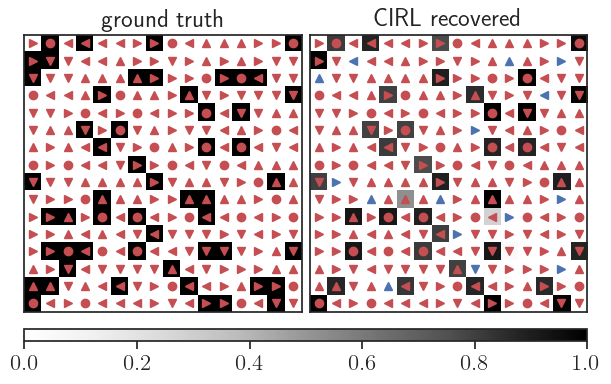

In [6]:
fig, axs = plt.subplots(1, 2, figsize=(6, 3.7), layout='constrained')
markers = ['o', '>', '<', '^', 'v']

im = None
for r_idx, rew in enumerate([r_exp, r_est]):
    rew = (rew - np.min(rew)) / (np.max(rew) - np.min(rew))
    im = axs[r_idx].imshow(rew.reshape(gridsize, gridsize), cmap='Greys')
fig.colorbar(im, ax=axs, location='bottom', aspect=50)

for p_idx, pol in enumerate([pi_exp, pi_est]):
    for s in range(num_states):
        a = np.argmax(pol[s])
        x, y = s // gridsize, s % gridsize
        c = 'r' if np.argmax(pi_exp[s]) == a else 'b'
        axs[p_idx].plot(x, y, color=c, marker=markers[a])

for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])

axs[0].set_title('ground truth')
axs[1].set_title('CIRL recovered')

# plt.tight_layout()
fig.savefig('../figures/gw_maps.pdf', bbox_inches='tight')